# Research Example: Color-Magnitude Diagram with Gaia

This notebook demonstrates how to:
1. Load Gaia photometric and astrometric data
2. Compute absolute magnitudes using parallaxes
3. Create color-magnitude diagrams (HR diagrams)
4. Identify stellar populations
5. Visualize stellar parameters from GSP-Phot

## Research Applications
- Studying stellar populations in the Galaxy
- Testing stellar evolution models
- Identifying unusual stars (white dwarfs, subdwarfs, etc.)
- Measuring distances to star clusters

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
import warnings
warnings.filterwarnings('ignore')

print("✅ All packages imported successfully")

✅ All packages imported successfully


## 2. Research Motivation

### The Color-Magnitude Diagram (Hertzsprung-Russell Diagram)

The CMD is one of the most fundamental tools in stellar astrophysics.

**Why CMDs are important:**
1. Reveal stellar evolutionary stages (main sequence, giants, white dwarfs)
2. Determine ages of stellar populations
3. Measure distances to star clusters
4. Test stellar evolution theory
5. Identify unusual or rare stellar types

### Gaia Mission
- All-sky astrometric survey
- Parallaxes for >1 billion stars
- Enables direct distance measurements (no photometric assumptions!)
- Multi-band photometry (G, BP, RP)
- Unprecedented precision for nearby stars

### Our Analysis
- Load Gaia photometry and parallaxes
- Compute absolute magnitudes
- Create CMD showing stellar populations
- Visualize stellar parameters (Teff, log g, [M/H], extinction)

## 3. Load Gaia Dataset

In [2]:
print("Loading Gaia data...")
# Load Gaia data in streaming mode
gaia_data = load_dataset(
    "MultimodalUniverse/gaia",
    split="train",
    streaming=True
)

print("✅ Gaia dataset loaded in streaming mode")

Loading Gaia data...


✅ Gaia dataset loaded in streaming mode


## 4. Collect Stars with Reliable Parallaxes

For accurate absolute magnitudes, we need:
- Positive parallax (parallax > 0)
- Good signal-to-noise (parallax/parallax_error > 5)
- Valid photometry in G, BP, and RP bands
- Not too distant (parallax > 0.5 mas for SNR)

In [3]:
stars = []
gaia_iter = iter(gaia_data)
n_stars = 10000  # Number of stars to collect

print(f"Collecting {n_stars} stars with good parallaxes...")

collected = 0
attempted = 0
max_attempts = 50000  # Don't loop forever

while collected < n_stars and attempted < max_attempts:
    try:
        star = next(gaia_iter)
        attempted += 1

        # Extract relevant data from nested dictionaries
        astrometry = star.get('astrometry', {})
        photometry = star.get('photometry', {})
        gspphot = star.get('gspphot', {})

        parallax = astrometry.get('parallax')
        parallax_error = astrometry.get('parallax_error')
        phot_g_mean_mag = photometry.get('phot_g_mean_mag')
        phot_bp_mean_mag = photometry.get('phot_bp_mean_mag')
        phot_rp_mean_mag = photometry.get('phot_rp_mean_mag')

        # Stellar parameters from GSP-Phot
        teff = gspphot.get('teff_gspphot')
        logg = gspphot.get('logg_gspphot')
        mh = gspphot.get('mh_gspphot')  # Metallicity [M/H]
        ag = gspphot.get('ag_gspphot')  # Extinction in G band
        ebpminrp = gspphot.get('ebpminrp_gspphot')  # Reddening E(BP-RP)

        # Quality cuts
        if parallax is None or parallax_error is None:
            continue
        if phot_g_mean_mag is None or phot_bp_mean_mag is None or phot_rp_mean_mag is None:
            continue

        # Convert to float and apply cuts
        parallax = float(parallax)
        parallax_error = float(parallax_error)

        # Require positive parallax with good SNR
        if parallax <= 0 or parallax_error <= 0:
            continue
        if parallax / parallax_error < 5:  # SNR > 5
            continue
        if parallax < 0.5:  # Not too distant (< 2 kpc)
            continue

        # Convert magnitudes to float
        g_mag = float(phot_g_mean_mag)
        bp_mag = float(phot_bp_mean_mag)
        rp_mag = float(phot_rp_mean_mag)

        # Compute distance (in parsecs)
        distance = 1000.0 / parallax  # parallax in mas -> distance in pc

        # Compute absolute magnitude
        abs_g_mag = g_mag - 5 * np.log10(distance) + 5

        # Compute color
        bp_rp_color = bp_mag - rp_mag

        stars.append({
            'source_id': star.get('object_id'),
            'ra': astrometry.get('ra'),
            'dec': astrometry.get('dec'),
            'parallax': parallax,
            'parallax_error': parallax_error,
            'distance': distance,
            'g_mag': g_mag,
            'bp_mag': bp_mag,
            'rp_mag': rp_mag,
            'abs_g_mag': abs_g_mag,
            'bp_rp_color': bp_rp_color,
            'teff': teff,
            'logg': logg,
            'mh': mh,
            'ag': ag,
            'ebpminrp': ebpminrp
        })

        collected += 1

        if collected % 1000 == 0:
            print(f"  Collected {collected}/{n_stars} stars (checked {attempted})...")

    except StopIteration:
        print(f"  Reached end of dataset after {attempted} stars")
        break
    except Exception as e:
        continue

stars_df = pd.DataFrame(stars)
print(f"\n✅ Collected {len(stars_df)} stars with reliable parallaxes")

  Collected 1000/10000 stars (checked 1243)...


  Collected 2000/10000 stars (checked 2509)...


  Collected 3000/10000 stars (checked 3735)...


  Collected 4000/10000 stars (checked 5009)...


  Collected 5000/10000 stars (checked 6253)...


  Collected 6000/10000 stars (checked 7503)...


  Collected 7000/10000 stars (checked 8780)...


  Collected 8000/10000 stars (checked 10078)...


  Collected 9000/10000 stars (checked 11325)...


  Collected 10000/10000 stars (checked 12590)...

✅ Collected 10000 stars with reliable parallaxes


## 5. Data Quality Summary

In [4]:
print(f"""
Sample Statistics:
- Number of stars: {len(stars_df)}
- Distance range: {stars_df['distance'].min():.1f} - {stars_df['distance'].max():.1f} pc
- Parallax range: {stars_df['parallax'].min():.2f} - {stars_df['parallax'].max():.2f} mas
- G magnitude range: {stars_df['g_mag'].min():.2f} - {stars_df['g_mag'].max():.2f}
- Absolute G magnitude range: {stars_df['abs_g_mag'].min():.2f} - {stars_df['abs_g_mag'].max():.2f}
- BP-RP color range: {stars_df['bp_rp_color'].min():.2f} - {stars_df['bp_rp_color'].max():.2f}
""")


Sample Statistics:
- Number of stars: 10000
- Distance range: 8.6 - 1999.8 pc
- Parallax range: 0.50 - 116.27 mas
- G magnitude range: 6.86 - 19.84
- Absolute G magnitude range: -2.37 - 15.84
- BP-RP color range: -0.46 - 5.23



## 6. Create Color-Magnitude Diagram

✅ Saved Color-Magnitude Diagram


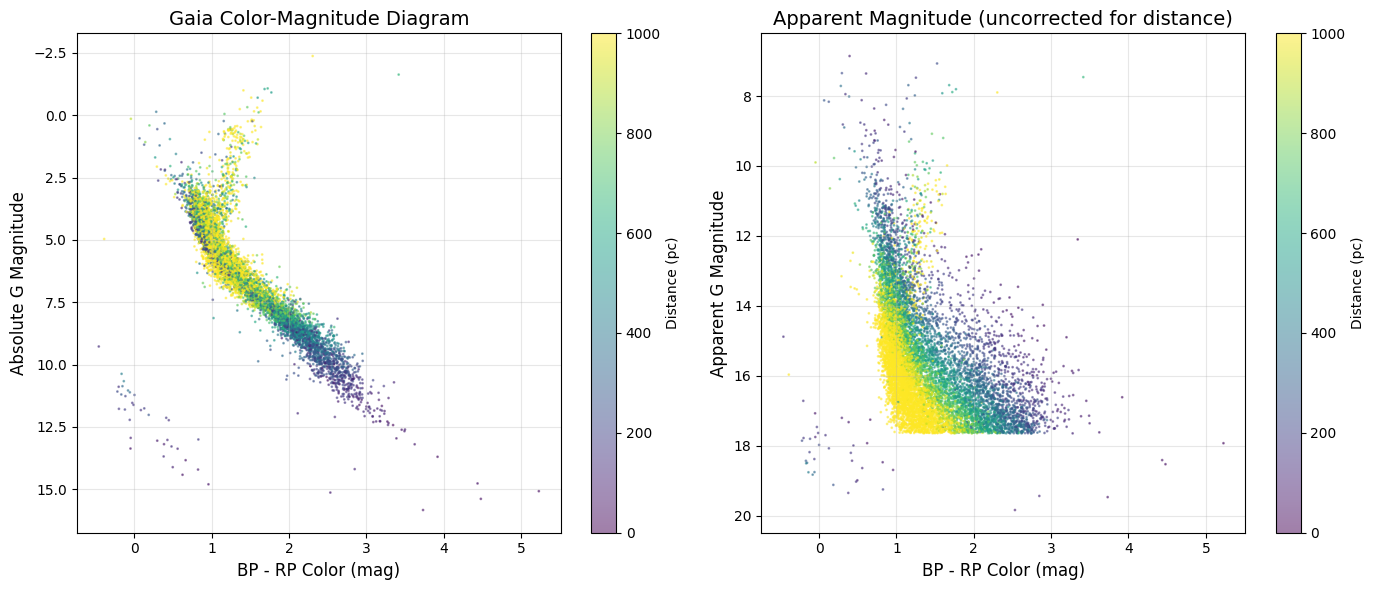

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Classic CMD (absolute magnitude vs color)
ax = axes[0]
scatter = ax.scatter(
    stars_df['bp_rp_color'],
    stars_df['abs_g_mag'],
    c=stars_df['distance'],
    s=1,
    alpha=0.5,
    cmap='viridis',
    vmin=0,
    vmax=1000
)
ax.invert_yaxis()  # Brighter stars at top
ax.set_xlabel('BP - RP Color (mag)', fontsize=12)
ax.set_ylabel('Absolute G Magnitude', fontsize=12)
ax.set_title('Gaia Color-Magnitude Diagram', fontsize=14)
ax.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Distance (pc)', fontsize=10)

# Plot 2: Apparent magnitude vs color (for comparison)
ax = axes[1]
scatter2 = ax.scatter(
    stars_df['bp_rp_color'],
    stars_df['g_mag'],
    c=stars_df['distance'],
    s=1,
    alpha=0.5,
    cmap='viridis',
    vmin=0,
    vmax=1000
)
ax.invert_yaxis()
ax.set_xlabel('BP - RP Color (mag)', fontsize=12)
ax.set_ylabel('Apparent G Magnitude', fontsize=12)
ax.set_title('Apparent Magnitude (uncorrected for distance)', fontsize=14)
ax.grid(True, alpha=0.3)

# Add colorbar
cbar2 = plt.colorbar(scatter2, ax=ax)
cbar2.set_label('Distance (pc)', fontsize=10)

plt.tight_layout()
plt.savefig('gaia_cmd.png', dpi=150, bbox_inches='tight')
print("✅ Saved Color-Magnitude Diagram")
plt.show()

## 7. Identify Stellar Populations

We can identify different stellar populations based on their position in the CMD:
- **Main Sequence**: diagonal band from blue/bright to red/faint
- **Red Giants**: bright, red stars (upper right)
- **White Dwarfs**: faint, blue stars (lower left)
- **Horizontal Branch**: horizontal feature in globular clusters

In [6]:
def classify_star(abs_mag, color):
    """Simple stellar classification based on CMD position"""

    # Convert amplitude to millimagnitudes (approximate)
    amp_mmag = -2.5 * np.log10(1 - 0.01) * 1000  # Placeholder

    # White dwarfs: faint and blue
    if abs_mag > 10 and color < 0.5:
        return "White Dwarf"

    # Red giants: bright and red
    elif abs_mag < 2 and color > 1.2:
        return "Red Giant"

    # Blue main sequence: bright and blue
    elif abs_mag < 5 and color < 0.5:
        return "Blue MS"

    # Red main sequence: faint and red
    elif 5 < abs_mag < 15 and 0.5 < color < 2.5:
        return "Red MS"

    # Sub-giants: intermediate
    elif 2 < abs_mag < 5 and 0.5 < color < 1.5:
        return "Sub-Giant"

    else:
        return "Other"

# Classify variables
stars_df['stellar_type'] = stars_df.apply(
    lambda row: classify_star(row['abs_g_mag'], row['bp_rp_color']),
    axis=1
)

# Show classification summary
print("\nStellar Population Counts:")
print("-" * 40)
var_counts = stars_df['stellar_type'].value_counts()
for pop, count in var_counts.items():
    percentage = 100 * count / len(stars_df)
    print(f"{pop:15s}: {count:6d} ({percentage:5.1f}%)")


Stellar Population Counts:
----------------------------------------
Red MS         :   6854 ( 68.5%)
Sub-Giant      :   2445 ( 24.4%)
Other          :    538 (  5.4%)
Red Giant      :    110 (  1.1%)
White Dwarf    :     28 (  0.3%)
Blue MS        :     25 (  0.2%)


## 8. CMD Showing Stellar Populations

✅ Saved CMD with populations


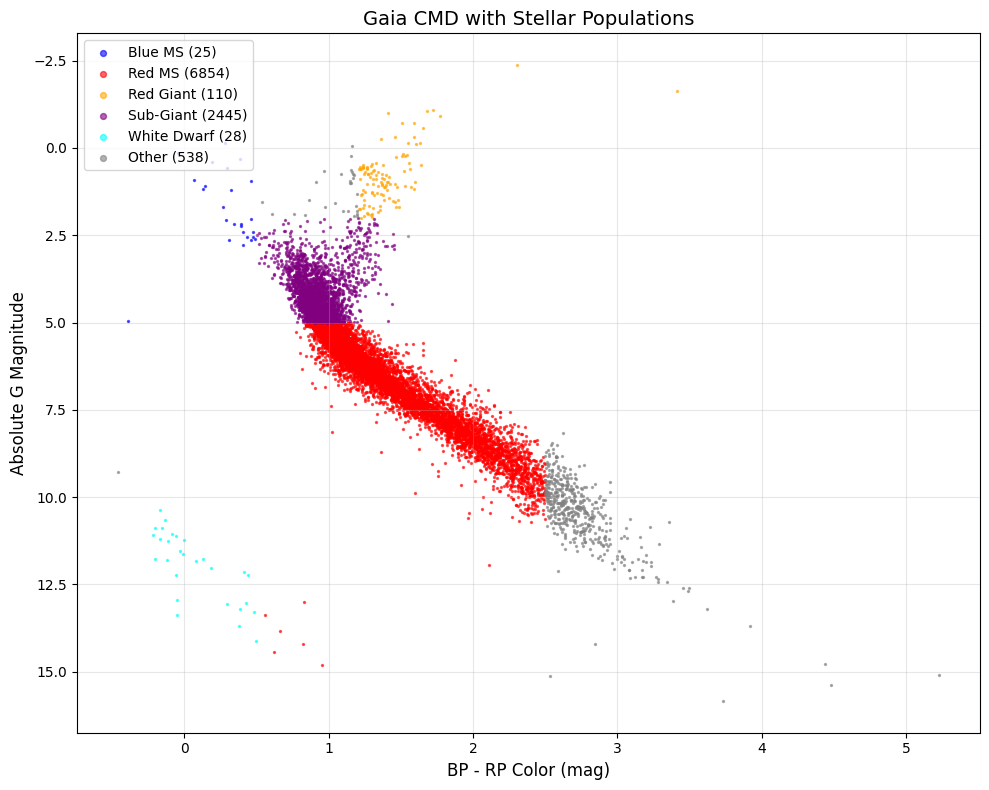

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each population with different colors
populations = ['Blue MS', 'Red MS', 'Red Giant', 'Sub-Giant', 'White Dwarf', 'Other']
colors_map = {
    'Blue MS': 'blue',
    'Red MS': 'red',
    'Red Giant': 'orange',
    'Sub-Giant': 'purple',
    'White Dwarf': 'cyan',
    'Other': 'gray'
}

for pop in populations:
    mask = stars_df['stellar_type'] == pop
    if mask.sum() > 0:
        ax.scatter(
            stars_df[mask]['bp_rp_color'],
            stars_df[mask]['abs_g_mag'],
            label=f'{pop} ({mask.sum()})',
            s=2,
            alpha=0.6,
            c=colors_map.get(pop, 'gray')
        )

ax.invert_yaxis()
ax.set_xlabel('BP - RP Color (mag)', fontsize=12)
ax.set_ylabel('Absolute G Magnitude', fontsize=12)
ax.set_title('Gaia CMD with Stellar Populations', fontsize=14)
ax.legend(loc='upper left', markerscale=3)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gaia_cmd_populations.png', dpi=150, bbox_inches='tight')
print("✅ Saved CMD with populations")
plt.show()

## 9. CMD Colored by Stellar Parameters

GSP-Phot provides stellar parameters estimated from Gaia photometry:
- **Teff**: Effective temperature (K)
- **log g**: Surface gravity (dex)
- **[M/H]**: Metallicity relative to solar
- **A_G**: Extinction in G band (mag)
- **E(BP-RP)**: Reddening (mag)

✅ Saved multi-parameter CMD


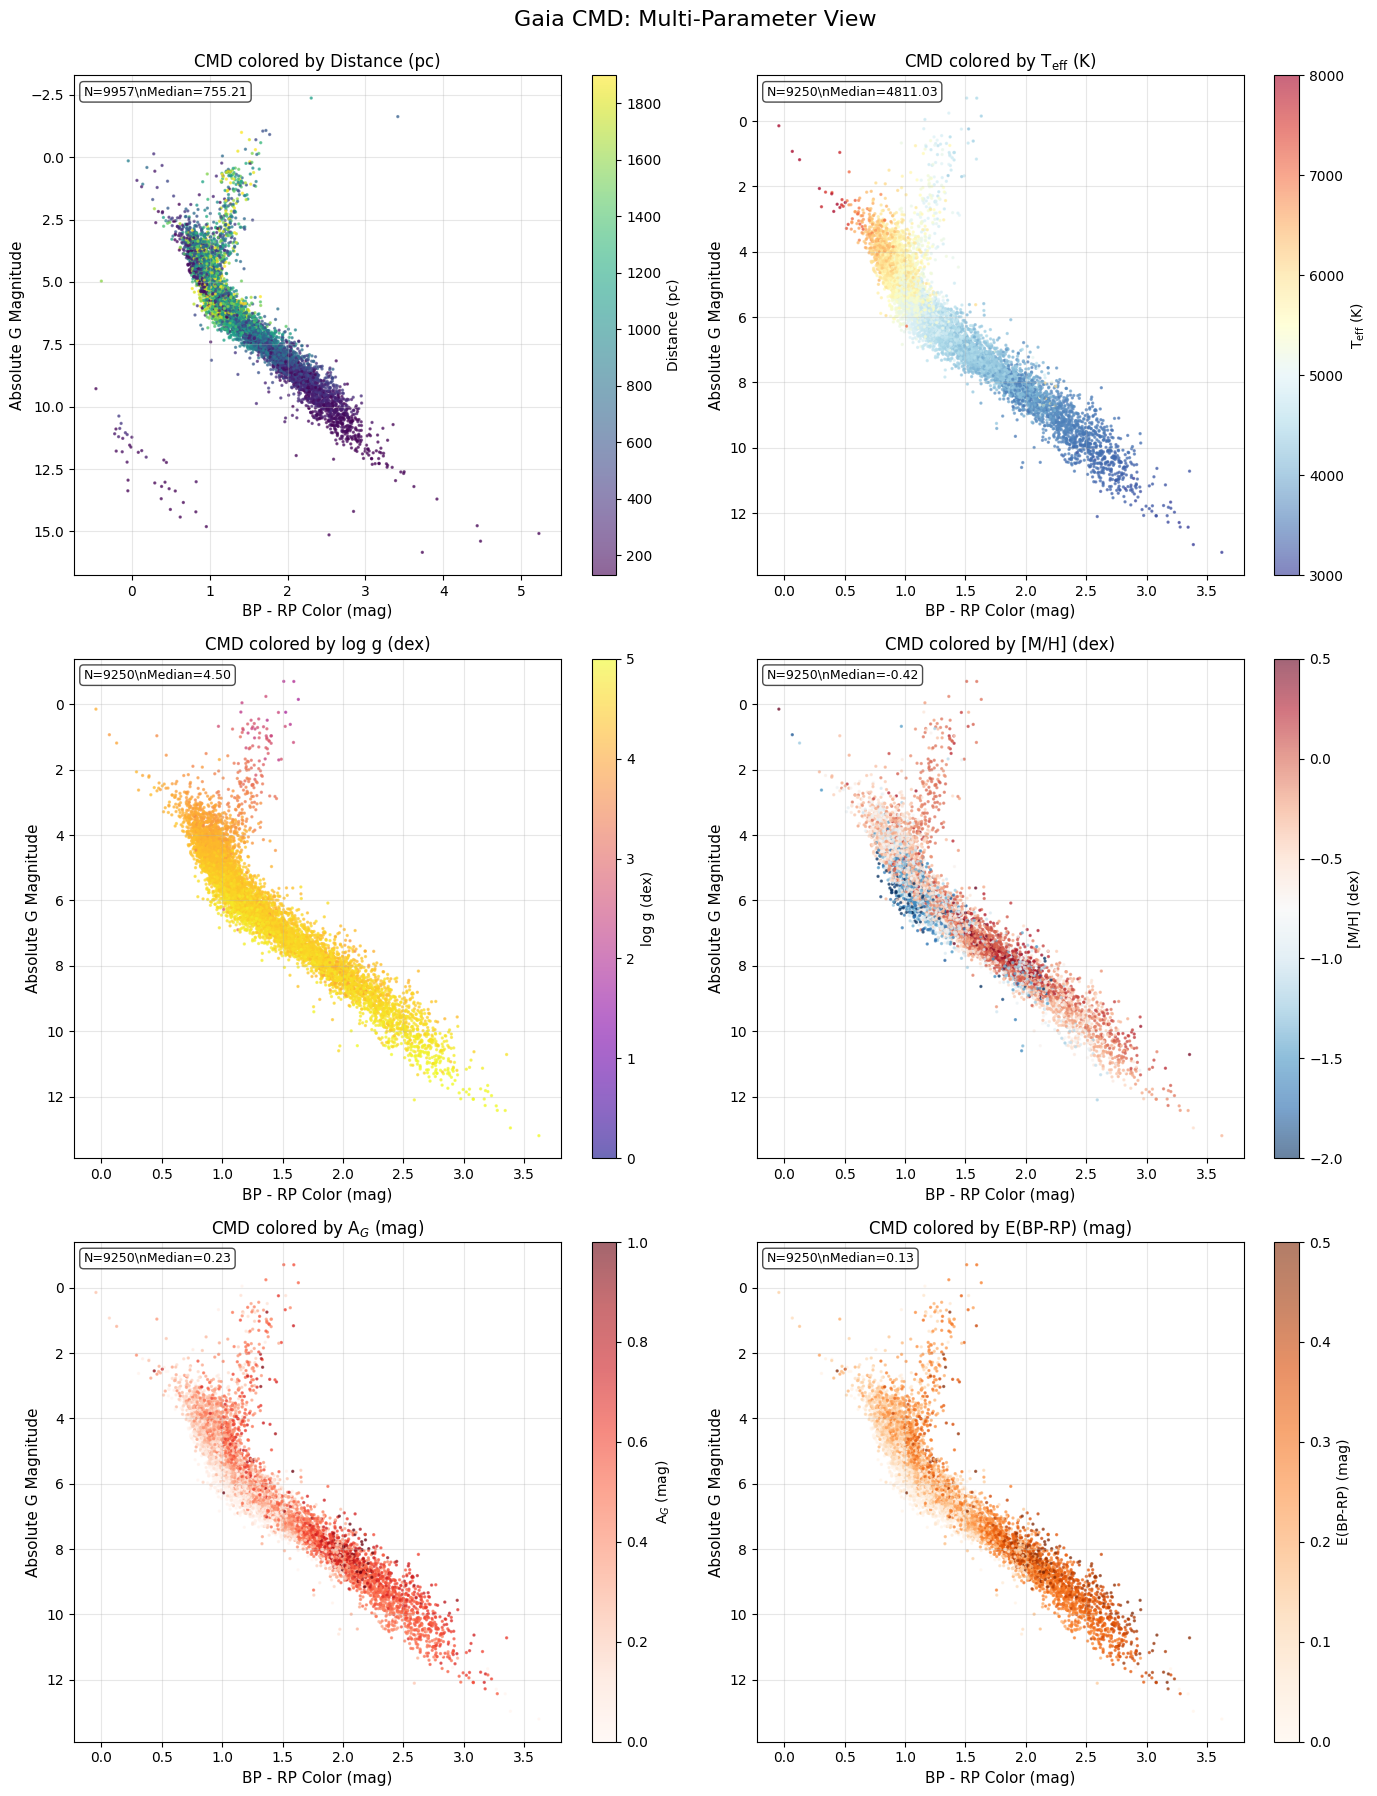

In [8]:
# Create a 3x2 multi-panel plot
fig, axes = plt.subplots(3, 2, figsize=(14, 18))
axes = axes.flatten()

# Prepare data (filter out NaN values for each parameter)
params = [
    ('distance', 'Distance (pc)', 'viridis', None, None),
    ('teff', 'T$_{\\rm eff}$ (K)', 'RdYlBu_r', 3000, 8000),
    ('logg', 'log g (dex)', 'plasma', 0, 5),
    ('mh', '[M/H] (dex)', 'RdBu_r', -2, 0.5),
    ('ag', 'A$_G$ (mag)', 'Reds', 0, 1),
    ('ebpminrp', 'E(BP-RP) (mag)', 'Oranges', 0, 0.5)
]

for idx, (param, label, cmap, vmin, vmax) in enumerate(params):
    ax = axes[idx]

    # Filter out NaN values for this parameter
    mask = stars_df[param].notna()
    data = stars_df[mask]

    if len(data) == 0:
        ax.text(0.5, 0.5, f'No {label} data', ha='center', va='center',
                transform=ax.transAxes, fontsize=12)
        ax.set_xlabel('BP - RP Color (mag)', fontsize=11)
        ax.set_ylabel('Absolute G Magnitude', fontsize=11)
        continue

    # Determine vmin/vmax if not specified
    if vmin is None:
        vmin = np.percentile(data[param], 2)
    if vmax is None:
        vmax = np.percentile(data[param], 98)

    scatter = ax.scatter(
        data['bp_rp_color'],
        data['abs_g_mag'],
        c=data[param],
        s=2,
        alpha=0.6,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax
    )

    ax.invert_yaxis()
    ax.set_xlabel('BP - RP Color (mag)', fontsize=11)
    ax.set_ylabel('Absolute G Magnitude', fontsize=11)
    ax.set_title(f'CMD colored by {label}', fontsize=12)
    ax.grid(True, alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(label, fontsize=10)

    # Add statistics
    median_val = np.median(data[param])
    n_stars = len(data)
    ax.text(0.02, 0.98, f'N={n_stars}\\nMedian={median_val:.2f}',
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.suptitle('Gaia CMD: Multi-Parameter View', fontsize=16, y=0.995)
plt.tight_layout()
plt.savefig('gaia_cmd_multiparameter.png', dpi=150, bbox_inches='tight')
print("✅ Saved multi-parameter CMD")
plt.show()

### Stellar Parameter Statistics

In [9]:
print("Stellar Parameter Statistics:")
print("-" * 60)
for param, label, _, _, _ in params:
    valid_data = stars_df[param].dropna()
    if len(valid_data) > 0:
        print(f"{label:20s}: {len(valid_data):5d} stars, "
              f"median = {np.median(valid_data):7.2f}, "
              f"range = [{valid_data.min():7.2f}, {valid_data.max():7.2f}]")
    else:
        print(f"{label:20s}: No data available")

Stellar Parameter Statistics:
------------------------------------------------------------
Distance (pc)       :  9957 stars, median =  755.21, range = [   8.60, 1999.85]
T$_{\rm eff}$ (K)   :  9250 stars, median = 4811.03, range = [2920.57, 12291.84]
log g (dex)         :  9250 stars, median =    4.50, range = [   1.83,    5.18]
[M/H] (dex)         :  9250 stars, median =   -0.42, range = [  -4.08,    0.76]
A$_G$ (mag)         :  9250 stars, median =    0.23, range = [   0.00,    2.79]
E(BP-RP) (mag)      :  9250 stars, median =    0.13, range = [   0.00,    1.55]


## 10. Distributions

✅ Saved distributions


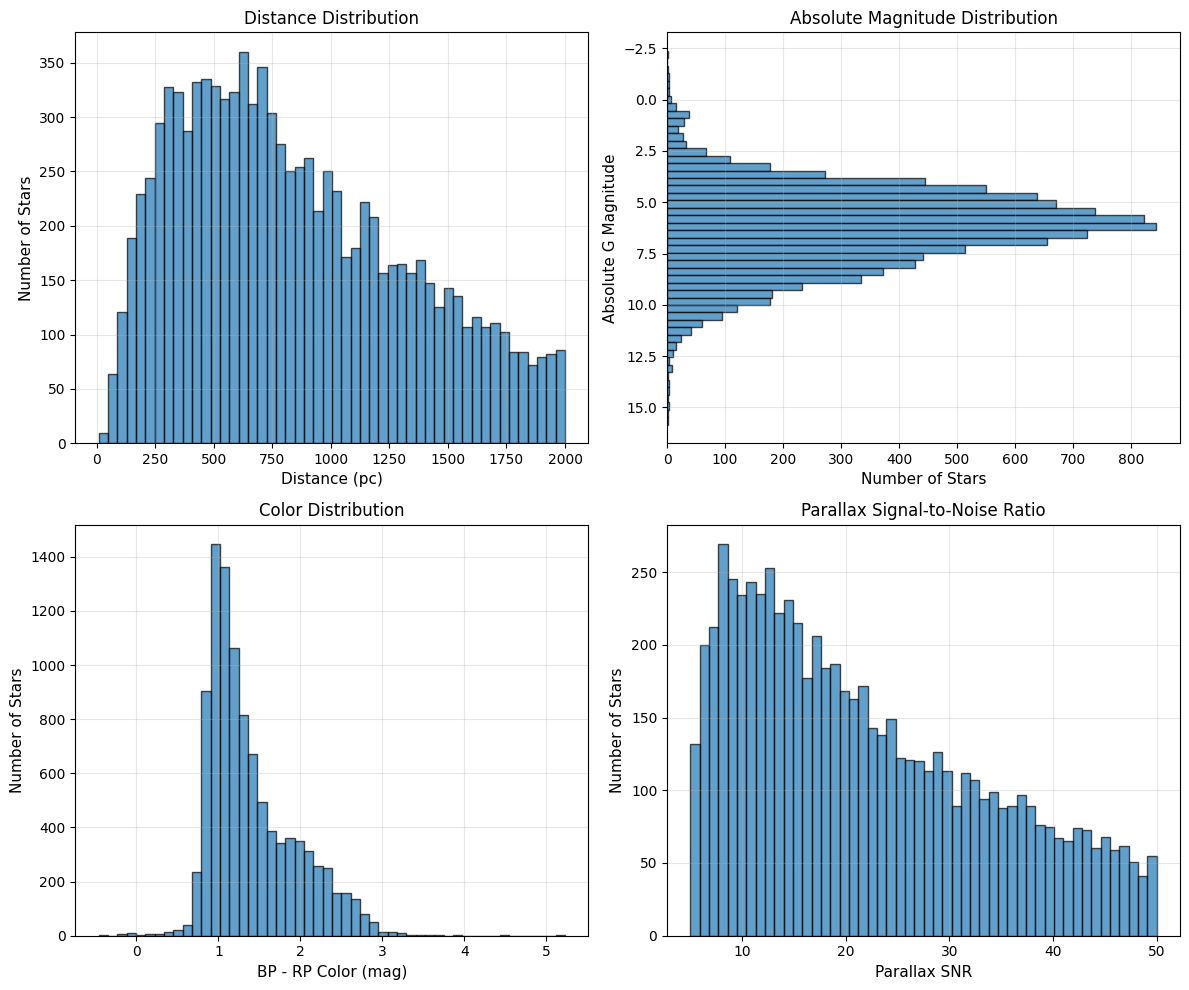

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Distance histogram
ax = axes[0, 0]
ax.hist(stars_df['distance'], bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('Distance (pc)', fontsize=11)
ax.set_ylabel('Number of Stars', fontsize=11)
ax.set_title('Distance Distribution', fontsize=12)
ax.grid(True, alpha=0.3)

# Plot 2: Absolute magnitude histogram
ax = axes[0, 1]
ax.hist(stars_df['abs_g_mag'], bins=50, edgecolor='black', alpha=0.7, orientation='horizontal')
ax.set_ylabel('Absolute G Magnitude', fontsize=11)
ax.set_xlabel('Number of Stars', fontsize=11)
ax.set_title('Absolute Magnitude Distribution', fontsize=12)
ax.invert_yaxis()
ax.grid(True, alpha=0.3)

# Plot 3: Color histogram
ax = axes[1, 0]
ax.hist(stars_df['bp_rp_color'], bins=50, edgecolor='black', alpha=0.7)
ax.set_xlabel('BP - RP Color (mag)', fontsize=11)
ax.set_ylabel('Number of Stars', fontsize=11)
ax.set_title('Color Distribution', fontsize=12)
ax.grid(True, alpha=0.3)

# Plot 4: Parallax SNR
ax = axes[1, 1]
snr = stars_df['parallax'] / stars_df['parallax_error']
ax.hist(snr, bins=50, range=(5, 50), edgecolor='black', alpha=0.7)
ax.set_xlabel('Parallax SNR', fontsize=11)
ax.set_ylabel('Number of Stars', fontsize=11)
ax.set_title('Parallax Signal-to-Noise Ratio', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('gaia_distributions.png', dpi=150, bbox_inches='tight')
print("✅ Saved distributions")
plt.show()

## 11. Save Results

In [11]:
# Save catalog
stars_df.to_csv('gaia_cmd_catalog.csv', index=False)
print("✅ Saved catalog to gaia_cmd_catalog.csv")

✅ Saved catalog to gaia_cmd_catalog.csv


## Summary

In this notebook, we:
1. Loaded Gaia astrometric and photometric data
2. Applied quality cuts for reliable parallaxes (SNR > 5)
3. Computed absolute magnitudes and colors
4. Created classic color-magnitude diagrams
5. Classified stars into stellar populations
6. Visualized stellar parameters (Teff, log g, [M/H], extinction)

The multi-parameter CMD reveals how stellar properties vary across the diagram, providing insights into stellar evolution and Galactic structure!